In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import tensorflow as tf
from src.Simulator.SSA import SSASimulator
import numpy as np

2023-08-23 11:09:08.053819: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-23 11:09:08.572321: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-23 11:09:08.574460: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-23 11:09:10.142443: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# NN for Birth Death Model
First, we build the dynamic model to create the training data

In [35]:
from src.Models.models import BirthDeath
model_bd = BirthDeath()
simulator_bd = SSASimulator(model_bd)

parameters = model_bd.getDefaultParameter()
y, t = simulator_bd.run_ssa(np.array([5]), 1000, parameters)
num_states = y.shape[1]

We set up the NN model

In [42]:
from src.Models.utils import getReactionsForObservations
from src.Estimation.NN import CTMCModel
from tensorflow.keras.initializers import Constant

reaction_indices, unique_reaction_mapping = getReactionsForObservations(y, model_bd.getStoichiometry())
num_unique_stoch = len(np.unique(unique_reaction_mapping))

Model = tf.keras.models.Sequential([
    tf.keras.layers.Input((num_states,)),
    tf.keras.layers.Dense(8, activation=tf.keras.activations.selu),
    tf.keras.layers.Dense(8, activation=tf.keras.activations.selu),
    tf.keras.layers.Dense(num_unique_stoch, activation=tf.keras.activations.softplus, kernel_initializer=Constant(0.1))
])

custom_model = CTMCModel(Model)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
custom_model.compile(optimizer)

times_spent = t[1:] - t[:-1]
# tf.config.experimental_run_functions_eagerly(True)
train_dataset = tf.data.Dataset.from_tensor_slices((y[:-1], times_spent, reaction_indices)).batch(256)

We train the model on the training data

In [43]:
custom_model.fit(train_dataset, epochs=1000)

Epoch 1/1000
8/8 [==============================] - 3s 85ms/step - loss: 245.9789
Epoch 2/1000
8/8 [==============================] - 1s 76ms/step - loss: 245.4316
Epoch 3/1000
8/8 [==============================] - 1s 82ms/step - loss: 245.1416
Epoch 4/1000
8/8 [==============================] - 1s 82ms/step - loss: 244.9827
Epoch 5/1000
8/8 [==============================] - 1s 84ms/step - loss: 244.7907
Epoch 6/1000
8/8 [==============================] - 1s 80ms/step - loss: 244.6013
Epoch 7/1000
8/8 [==============================] - 1s 87ms/step - loss: 244.4319
Epoch 8/1000
8/8 [==============================] - 1s 98ms/step - loss: 244.2844
Epoch 9/1000
8/8 [==============================] - 1s 106ms/step - loss: 244.1394
Epoch 10/1000
8/8 [==============================] - 1s 119ms/step - loss: 243.9970
Epoch 11/1000
8/8 [==============================] - 1s 90ms/step - loss: 243.8645
Epoch 12/1000
8/8 [==============================] - 1s 95ms/step - loss: 243.7441
Epoch 13/10

We plot the estimation results

61/61 [==============================] - 0s 2ms/step
Mean Squared Error between NN predictions and expected propensities: 0.0021576718793122444


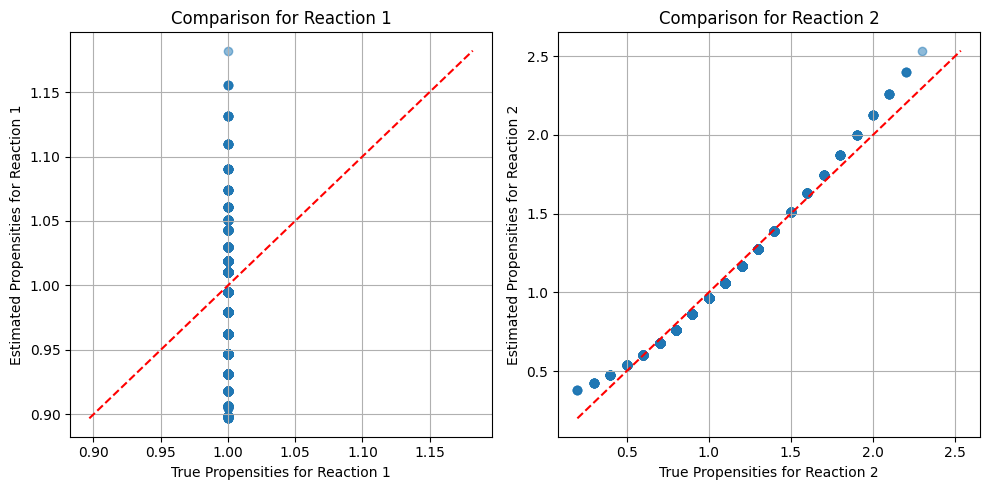

In [44]:
from src.Estimation.utils import createPropensityPlot
nn_predictions = custom_model.predict(y)

# get true propensities
true_props = np.array([model_bd.getPropensities(obs, time) for obs, time in zip(y, t)])
true_props_unique = np.zeros(shape=(true_props.shape[0], num_unique_stoch))
for rct, rct_map in enumerate(unique_reaction_mapping):
    true_props_unique[:, rct_map] += true_props[:, rct]

comparison = nn_predictions - true_props_unique

mse = np.mean(np.square(comparison))
print(f"Mean Squared Error between NN predictions and expected propensities: {mse}")

fig = createPropensityPlot(nn_predictions, true_props_unique)

Lets compare it with the MLE 

/tmp/ipykernel_31378/1519838007.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


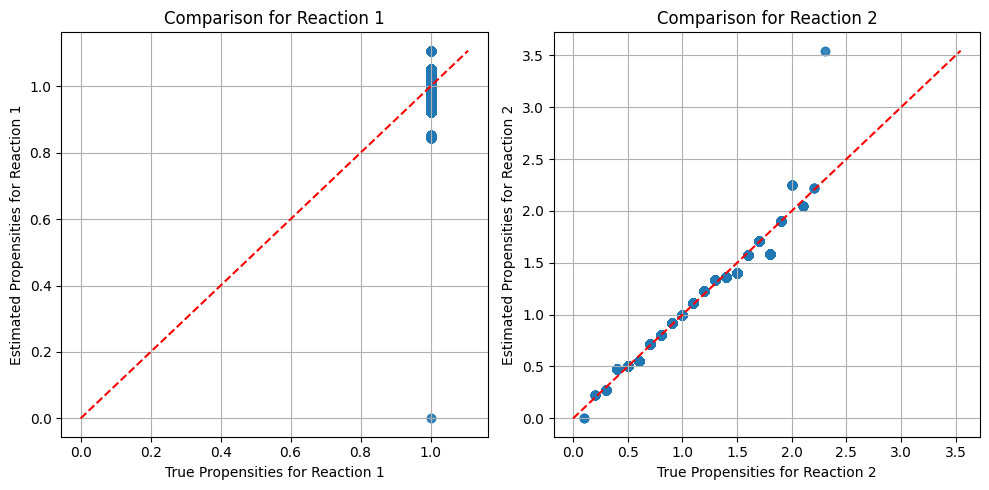

In [34]:
from src.Estimation.MLE import MLEstimator
estimator = MLEstimator(model_bd, y, t)
mle_matrix = estimator.computeMLETransitionMatrix()
fig = estimator.plotMLEstimates(mle_matrix)
fig.show()

# NN for Lotka-Voltera Model

In [45]:
from src.Models.models import ThreeSpeciesModel
model_lv = ThreeSpeciesModel()
simulator_lv = SSASimulator(model_lv)

parameters = model_lv.getDefaultParameter()
y, t = simulator_lv.run_ssa(np.array([80000, 10, 10]), 1000, parameters)
num_states = y.shape[1]

In [46]:
from src.Models.utils import getReactionsForObservations
from src.Estimation.NN import CTMCModel
from tensorflow.keras.initializers import Constant

reaction_indices, unique_reaction_mapping = getReactionsForObservations(y, model_lv.getStoichiometry())
num_unique_stoch = len(np.unique(unique_reaction_mapping))

Model = tf.keras.models.Sequential([
    tf.keras.layers.Input((num_states,)),
    tf.keras.layers.Dense(64, activation=tf.keras.activations.selu),
    tf.keras.layers.Dense(64, activation=tf.keras.activations.selu),
    tf.keras.layers.Dense(64, activation=tf.keras.activations.selu),
    tf.keras.layers.Dense(num_unique_stoch, activation=tf.keras.activations.softplus, kernel_initializer=Constant(0.1))
])

custom_model = CTMCModel(Model)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
custom_model.compile(optimizer)

times_spent = t[1:] - t[:-1]
# tf.config.experimental_run_functions_eagerly(True)
train_dataset = tf.data.Dataset.from_tensor_slices((y[:-1], times_spent, reaction_indices)).batch(512)

In [ ]:
custom_model.fit(train_dataset, epochs=200)

Epoch 1/200
64/64 [==============================] - 9s 116ms/step - loss: 270244.0938
Epoch 2/200
64/64 [==============================] - 8s 128ms/step - loss: 181.7197
Epoch 3/200
64/64 [==============================] - 9s 142ms/step - loss: -225.6313
Epoch 4/200
64/64 [==============================] - 8s 127ms/step - loss: -258.2619
Epoch 5/200
64/64 [==============================] - 8s 126ms/step - loss: -185.2019
Epoch 6/200
64/64 [==============================] - 8s 126ms/step - loss: -251.0150
Epoch 7/200
64/64 [==============================] - 9s 135ms/step - loss: -133.0303
Epoch 8/200
64/64 [==============================] - 9s 133ms/step - loss: -239.8355
Epoch 9/200
64/64 [==============================] - 9s 142ms/step - loss: -262.9503
Epoch 10/200
64/64 [==============================] - 10s 157ms/step - loss: -265.8272
Epoch 11/200
64/64 [==============================] - 10s 152ms/step - loss: -267.1075
Epoch 12/200
64/64 [==============================] - 10s 15

1028/1028 [==============================] - 2s 2ms/step
Mean Squared Error between NN predictions and expected propensities: 7.6171736499230605


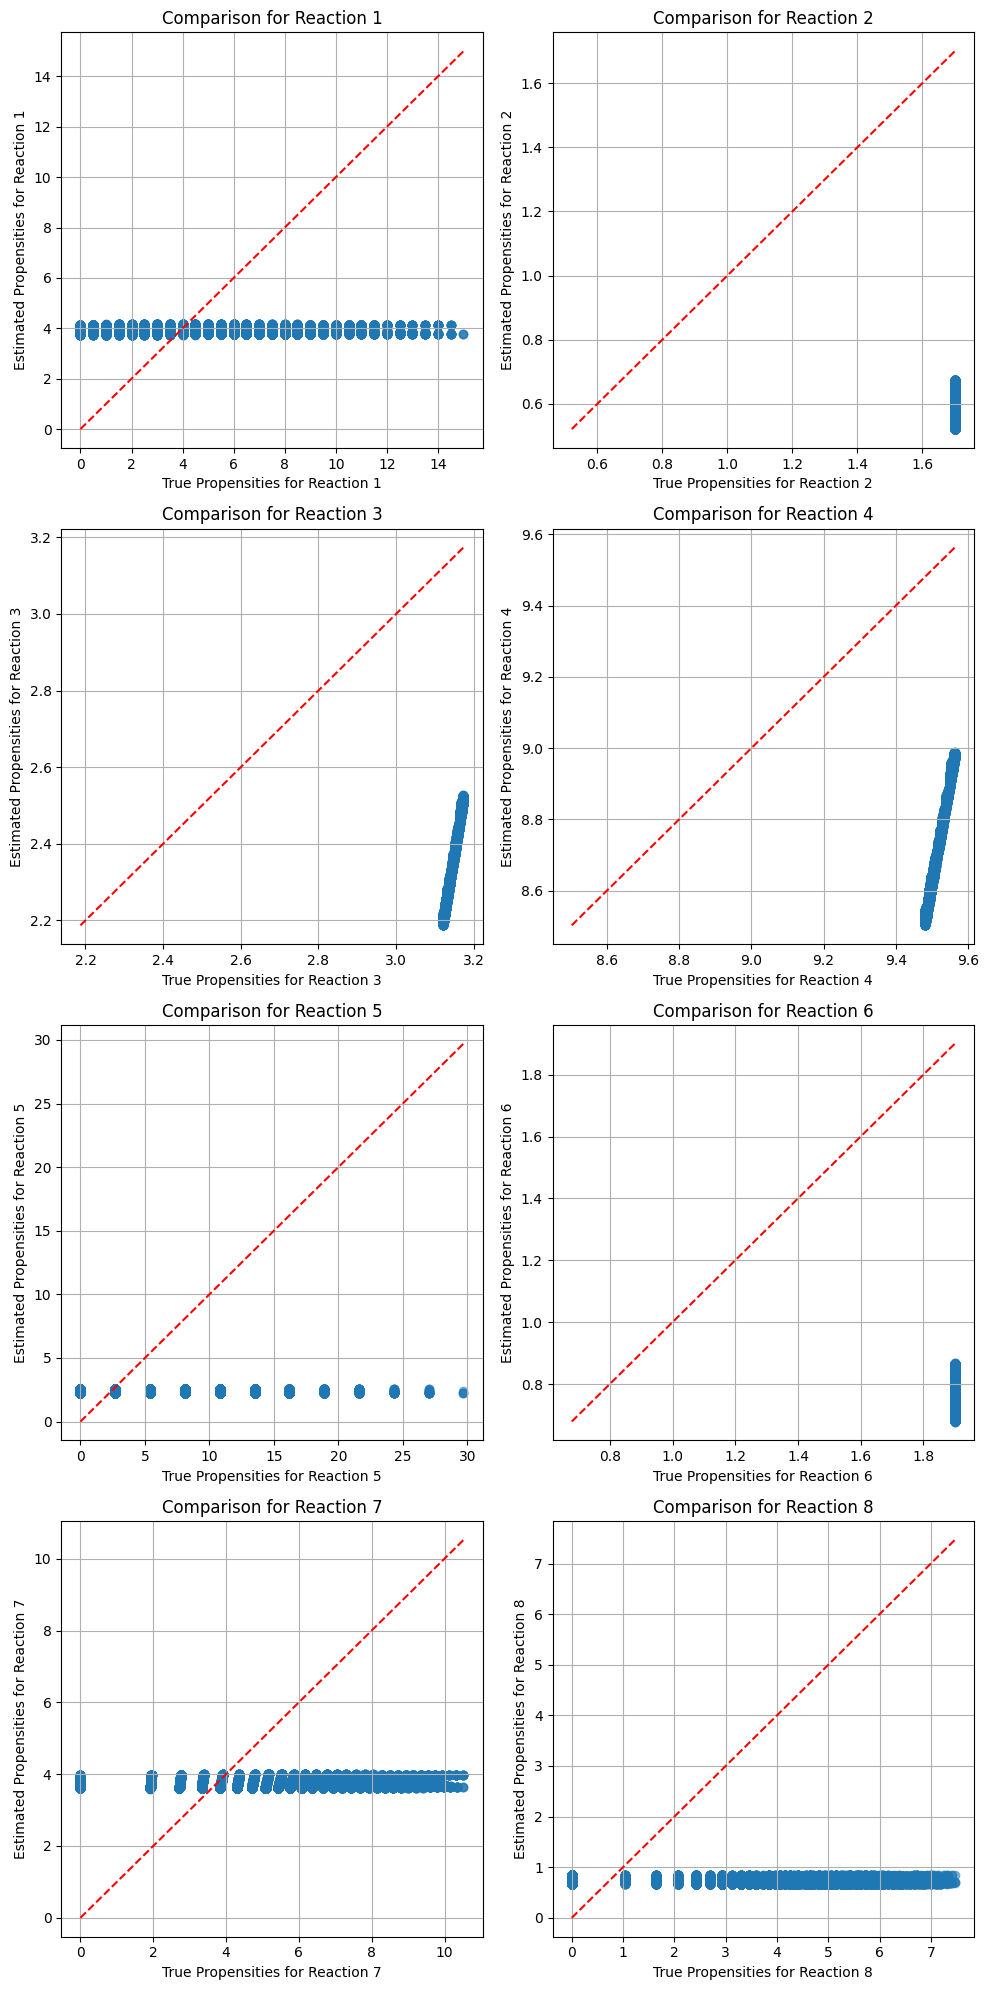

In [23]:
from src.Estimation.utils import createPropensityPlot
nn_predictions = custom_model.predict(y)

# get true propensities
true_props = np.array([model_lv.getPropensities(obs, time) for obs, time in zip(y, t)])
true_props_unique = np.zeros(shape=(true_props.shape[0], num_unique_stoch))
for rct, rct_map in enumerate(unique_reaction_mapping):
    true_props_unique[:, rct_map] += true_props[:, rct]

comparison = nn_predictions - true_props_unique

mse = np.mean(np.square(comparison))
print(f"Mean Squared Error between NN predictions and expected propensities: {mse}")

fig = createPropensityPlot(nn_predictions, true_props_unique)